# Demand Forecasting

This notebook consists of an exporatory data analysis and a LSTM neural network forecast modelling for Gastromatic. The objective of the problem is to forecast 14 days worth of sales data over the 32 kinds of products using a 3 year historical sales dataset.

The data consists of 3 CSV spreadsheets compressed into a zip. The data fields are:
- kind: The kind of product
- time: The hourly time this product was sold
- cancellation: A numerical boolean indicating a purchase cancellation
- guests: The number of quests
- group: The category of the product kind
- table: The table number
- article_number: The purchase ID
- ticket: The ticket ID
- invoice_closed: The time the invoice closed
- invoice_close: The time the request to close an invoice started
- invoice_opened: The time the invoice was opened

## 1. Load libraries

In [98]:
import tensorflow as tf
from zipfile import ZipFile
import urllib.request as ur
from sklearn import linear_model
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Load data from URL

In [2]:
CSV_DATA_ZIP_ENDPOINT = "https://www.dropbox.com/sh/0fcqy5qxqhfk8iy/AAAxSM4y_7aY03LhOmOj5Rnna?dl=1"
ur.urlretrieve(CSV_DATA_ZIP_ENDPOINT, "data.zip")

In [3]:
# Extract zip file
ZipFile("data.zip").extractall(path="data")
filepaths = list(map(lambda v:"./data/%s" % v, os.listdir("data")))
filepaths

['./data/POS_data_2018.csv',
 './data/POS_data_2017.csv',
 './data/POS_data_2016.csv',
 './data/POS_data_2015.csv']

In [4]:
# merge all files into one dataframe
dfs = list(map(lambda file: pd.read_csv(file), filepaths))
df = pd.concat(dfs)
df.time = pd.to_datetime(df.time)
df.index = df.time
df.guests = df.guests.astype("category")
df.head()

,Unnamed: 0,kind,invoice_closed,invoice_opened,guests,group,invoice,cancellation,ticket,table,time,article_number,invoice_close
time,,,,,,,,,,,,,
2017-12-31 11:52:00,0,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Essen,3790,0,2289,101/1,2017-12-31 11:52:00,206,NaN
2017-12-31 11:52:00,1,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Speisen,3790,0,2289,101/1,2017-12-31 11:52:00,213,NaN
2017-12-31 11:52:00,2,Limonaden,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Getränke,3790,0,2289,101/1,2017-12-31 11:52:00,56,NaN
2017-12-31 11:52:00,3,Undefiniert,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Undefiniert,3790,0,2289,101/1,2017-12-31 11:52:00,262,NaN
2017-12-31 12:18:00,4,Weisswein offen,2017-12-31 13:20:00,2017-12-31 12:18:00,5,Getränke,3794,0,2292,116/1,2017-12-31 12:18:00,334,NaN


## 3. Missing Values Detection:

In [5]:
# filter null values
df.dropna()

# filter "Undefiniert" values
nulls = df[df.kind.apply(lambda k: k == "Undefiniert")]
print("Removed %s null rows" % nulls.count(axis=0).kind)
df = df[df.kind.apply(lambda k: k != "Undefiniert")]
df.head()

Removed 46729 null rows


,Unnamed: 0,kind,invoice_closed,invoice_opened,guests,group,invoice,cancellation,ticket,table,time,article_number,invoice_close
time,,,,,,,,,,,,,
2017-12-31 11:52:00,0,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Essen,3790,0,2289,101/1,2017-12-31 11:52:00,206,NaN
2017-12-31 11:52:00,1,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Speisen,3790,0,2289,101/1,2017-12-31 11:52:00,213,NaN
2017-12-31 11:52:00,2,Limonaden,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Getränke,3790,0,2289,101/1,2017-12-31 11:52:00,56,NaN
2017-12-31 12:18:00,4,Weisswein offen,2017-12-31 13:20:00,2017-12-31 12:18:00,5,Getränke,3794,0,2292,116/1,2017-12-31 12:18:00,334,NaN
2017-12-31 12:18:00,5,Bier,2017-12-31 13:20:00,2017-12-31 12:18:00,5,Getränke,3794,0,2292,116/1,2017-12-31 12:18:00,135,NaN


## 4. Exploratory data analysis

In [7]:
# Viewing all kind categories
kinds = pd.unique(df["kind"].to_numpy().ravel())
groups = pd.unique(df["group"].to_numpy().ravel())
print("Kinds: %s\n\nGroups: %s" % (kinds, groups))

Kinds: ['Pasta' 'Limonaden' 'Weisswein offen' 'Bier' 'Getränke' 'Antipasti'
 'Wasser' 'al forno' 'Pizza' 'Gnocci' 'Kaffee/Schoko' 'Schorlen' 'Salate'
 'Dolci' 'Specials' 'Aperitiv' 'Cocktail alkfrei' 'Extrabeilagen'
 'Suppen ' 'Säfte' 'Spirituosen' 'Cocktail' 'Eis' 'Salat'
 'Handelswaren / Divers' 'Infotexte' 'Mittagstisch' 'Rotwein offen'
 'Prosecco' 'Weisswein Flasche' 'Rotwein Flasche' 'Suppe']

Groups: ['Essen' 'Speisen' 'Getränke ' 'Getränke' 'Undefiniert' 'Handel' 'SYSTEM']


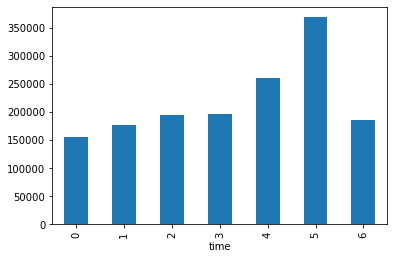

In [8]:
# Look at most demand per weekday
df.groupby(df.time.dt.dayofweek).time.count().plot(kind="bar")

> Here is seems Sundays don't bother the number of sales, but Saturdays are the most common day to buy.

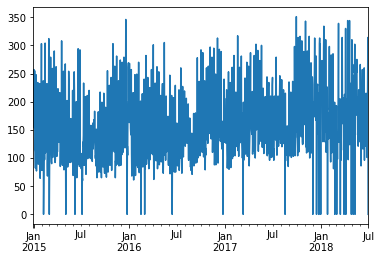

In [224]:
# Look at demand for single product over time
GRANULARITY = "D"
min_date = df.index.min()
max_date = df.index.max()
time_index = pd.date_range(
        start=min_date, end=max_date, normalize=True)

def get_kind_ts(kind, remove_outliers=True):
    single_kind = df[df.kind.apply(lambda k: k == kind)]
    single_kind = single_kind.resample(GRANULARITY).count()
    
    if remove_outliers:
        # remove outliers lower and upper quantile
        q_low = single_kind.time.quantile(0.01)
        q_hi  = single_kind.time.quantile(0.99)
        single_kind = single_kind[(single_kind.time < q_hi) & (single_kind.time > q_low)]
    
    time_spaced = pd.DataFrame(index=time_index, columns=["qty"])
    time_spaced = time_spaced.resample(GRANULARITY).count()
    
    for index, row in single_kind.iterrows():
        time_spaced.loc[index] = row.kind
    
    return time_spaced

# Augment data with periodic time data
def augment_data(data):
    return pd.DataFrame(
        data={
            "dayofweek": data.index.dayofweek,
            "dayofmonth": data.index.day,
            "week": data.index.week,
            "month": data.index.month,
            "qty": data.qty
        },
        index = data.index,
    )

sales_pasta = get_kind_ts("Pasta")
sales_pasta = augment_data(sales_pasta)
sales_pasta.qty.plot()

## 5. Normalize data

Here we use z-score normalization where the mean is 0 and the standard deviation is 1 for all values.

In [226]:
EPSILON = 1e-6
def normalize(df):
    norm = pd.DataFrame(index=df.index)
    z_values = {}
    for key in df:
        array = df[key]
        mean = array.mean()
        std = array.std()
        z_values[key] = (mean, std)
        norm[key] = (array - mean) / (std + EPSILON)
    return norm, z_values

def denormalize(df, z_values):
    denorm = pd.DataFrame(index=df.index)
    for key in df:
        (mean, std) = z_values[key]
        denorm[key] = (df[key] * std) + mean
    return denorm

pasta_norm, pasta_zv = normalize(pasta)
print(pasta_norm.head())
denormalize(pasta_norm, pasta_zv).head()

            dayofweek  dayofmonth      week     month       qty
time                                                           
2014-12-31  -0.499510    1.737613 -1.597923  1.726127  1.189974
2015-01-01   0.003215   -1.678091 -1.597923 -1.494214  0.058617
2015-01-02   0.505939   -1.564234 -1.597923 -1.494214  1.816572
2015-01-03   1.008664   -1.450377 -1.597923 -1.494214  1.572895
2015-01-04   1.511388   -1.336520 -1.597923 -1.494214  0.006400


,dayofweek,dayofmonth,week,month,qty
time,,,,,
2014-12-31,2.000000,30.999998,1.000002,11.999998,220.999999
2015-01-01,3.000000,1.000002,1.000002,1.000001,156.000000
2015-01-02,3.999999,2.000002,1.000002,1.000001,256.999998
2015-01-03,4.999999,3.000001,1.000002,1.000001,242.999998
2015-01-04,5.999998,4.000001,1.000002,1.000001,153.000000


## 5. Create baseline model

We use linear approximation as a baseline due to its simplicity and understandability before moving towards more complex models.

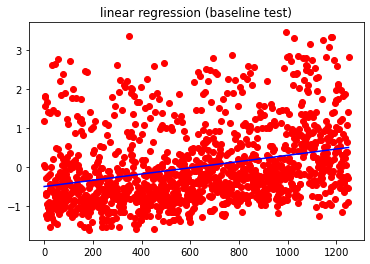

In [227]:
ys = pasta_norm.qty.values
xs = np.arange(0,ys.size,1)

xs = xs.reshape(-1, 1)
ys = ys.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(xs, ys)
plt.scatter(xs, ys, color="red")
plt.plot(xs, regr.predict(xs), color="blue")
plt.title("linear regression (baseline test)")
plt.show()

In [34]:
# Our baseline that we will improve on
mse = tf.divide(tf.keras.backend.sum(tf.sqrt(tf.keras.backend.sum(tf.square(xs - regr.predict(xs))))), len(xs))
"Linear regression (baseline) mse error: %s" % mse.numpy()

'Linear regression (baseline) mse error: 20.404249115582516'

## 7. Create LSTM model

The Long Short Term Memory (LSTM) neural network model is trained over windowed timeseries in order to generate a sequence. The input data is not shuffled because the windowed data needs to be ordered and for the validation results to account for the newly timed data outside of the training scope. The model capacity is increased with stacked LSTM with dropout pattern yielding a better accuracy. To improve training speed, the number of epochs are reduced and the learning rate is increased.

In [234]:
# Configurable hyperparameters
LOOK_BACK = 104
LOOK_AHEAD = 14
BATCH_SIZE = 20
EPOCHS = 1
LSTM_UNITS = 64
LEARNING_RATE = 0.01

INITIAL_CHPT_PATH = "initial_ckpt"
feature_len = len(pasta.values[0])

# Create LSTM model
inputs = tf.keras.layers.Input(shape=(LOOK_BACK, feature_len))
lstm_out1 = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=False)(inputs)
#lstm_out2 = tf.keras.layers.LSTM(LSTM_UNITS)(lstm_out1)
outputs = tf.keras.layers.Dense(units=LOOK_AHEAD, activation="linear")(lstm_out1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
model.summary()

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
)

# Save initial weights to reset after training new products
model.save_weights(INITIAL_CHPT_PATH)

def split_window(features):
    total_window_size = LOOK_BACK + LOOK_AHEAD
    input_slice = slice(0, LOOK_BACK)
    label_start = total_window_size - LOOK_AHEAD
    labels_slice = slice(label_start, None)
    
    inputs = features[:, input_slice, :]
    labels = features[:, labels_slice, 4]

    return inputs, labels

def create_dataset(data, shuffle=False):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=LOOK_BACK+LOOK_AHEAD,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )
    dataset = dataset.map(split_window)
    
    return dataset

def split_and_train(dataset, name="unnamed"):
    # split 60% train, 30% batch, 10% test
    split_train_val = int(len(dataset) * 0.6)
    split_val_test = int(len(dataset) * 0.9)

    train_data = dataset[:split_train_val]
    val_data = dataset[split_train_val:split_val_test]
    test_data = dataset[split_val_test:]

    train_batched = create_dataset(train_data, shuffle=False)
    val_batched = create_dataset(val_data)
    
    # reset model weights
    model.load_weights(INITIAL_CHPT_PATH)
    
    model_ckpt = modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=name,
        save_weights_only=True,
        save_best_only=True,
    ) 
    
    history = model.fit(
        train_batched,
        epochs=EPOCHS,
        validation_data=val_batched,
        callbacks=[es_callback, model_ckpt]
    )
    return history, test_data

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


history, pasta_test_norm = split_and_train(pasta_norm, "test-pasta")

visualize_loss(history, "Training and Validation Loss")

Model: "functional_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 104, 5)]          0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_56 (Dense)             (None, 14)                910       
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________________
 5/32 [===>..........................] - ETA: 1s - loss: 0.9042

KeyboardInterrupt: 

## 8. Forecast with test data

            qty
2018-06-30  152
2018-07-01  116
2018-07-02  111
2018-07-03  109
2018-07-04  149
2018-07-05  202
2018-07-06  212
2018-07-07  131
2018-07-08  100
2018-07-09  110
2018-07-10  118
2018-07-11  156
2018-07-12  191
2018-07-13  197
Sum of predicted sales 14 days ahead: 2061


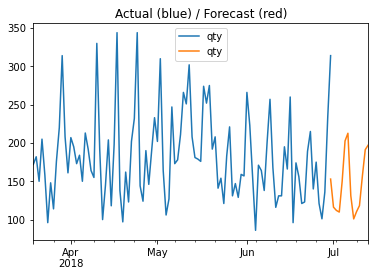

In [199]:
def forecast_model(test_data, z_values, model_ckpt_path, title="Actual (blue) / Forecast (red)"):
    model.load_weights(model_ckpt_path)
    input = test_data[-LOOK_BACK:]
    last_date = test_data.index.max()
    actual = pd.DataFrame(
        data=input.qty.values,
        columns=["qty"],
        index=pd.date_range(end=last_date, periods=LOOK_BACK, normalize=True)
    )
    pred = pd.DataFrame(
        data=model.predict(input.values.reshape(1, LOOK_BACK, feature_len))[0],
        columns=["qty"],
        index=pd.date_range(start=last_date, periods=LOOK_AHEAD, normalize=True)
    )

    actual = denormalize(actual, z_values)
    pred = denormalize(pred, z_values)
    print(pred.astype(int))

    ax = actual.plot(label="Actual", title=title)
    pred.plot(ax = ax, label="Forecast")

    print("Sum of predicted sales %s days ahead: %s" % (LOOK_AHEAD, int(pred.sum())))
    
forecast_model(pasta_test_norm, pasta_zv, "test-pasta")

## 9. Batch training over all products

Training for kind: Pasta
33/33 [==============================] - 2s 67ms/step - loss: 0.7225 - val_loss: 1.1804


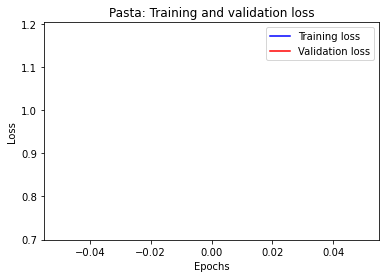

Training for kind: Limonaden
33/33 [==============================] - 2s 59ms/step - loss: 0.8173 - val_loss: 0.9045


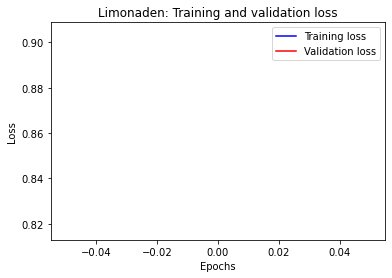

Training for kind: Weisswein offen
33/33 [==============================] - 2s 59ms/step - loss: 0.7461 - val_loss: 0.8995


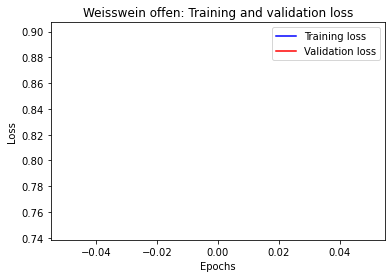

Training for kind: Bier
33/33 [==============================] - 2s 57ms/step - loss: 0.8175 - val_loss: 0.7995


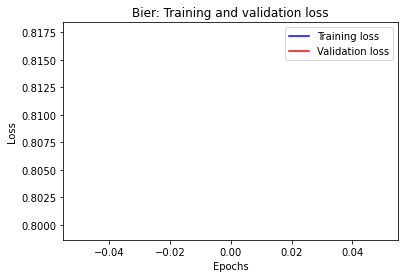

Training for kind: Getränke
33/33 [==============================] - 2s 54ms/step - loss: 0.0608 - val_loss: 1.4205


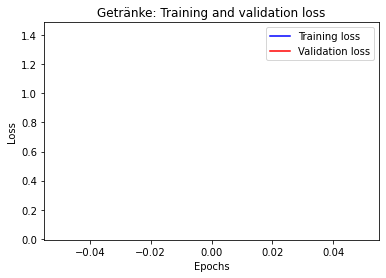

Training for kind: Antipasti
33/33 [==============================] - 2s 53ms/step - loss: 0.9840 - val_loss: 0.5917


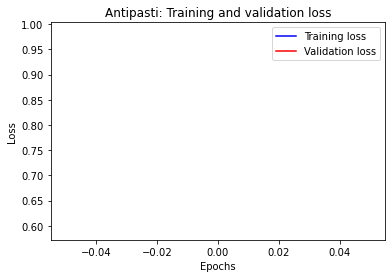

Training for kind: Wasser
33/33 [==============================] - 2s 54ms/step - loss: 0.7353 - val_loss: 1.0503


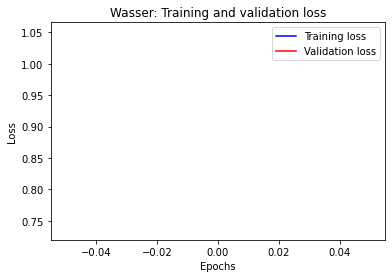

Training for kind: al forno
33/33 [==============================] - 2s 53ms/step - loss: 1.0408 - val_loss: 0.8351


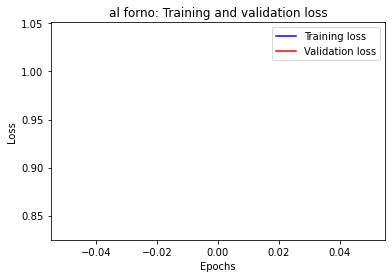

Training for kind: Pizza
33/33 [==============================] - 2s 54ms/step - loss: 0.7761 - val_loss: 0.7864


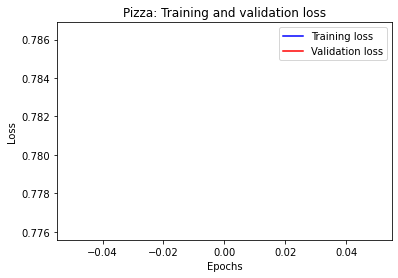

Training for kind: Gnocci
33/33 [==============================] - 2s 50ms/step - loss: 0.6918 - val_loss: 0.8784


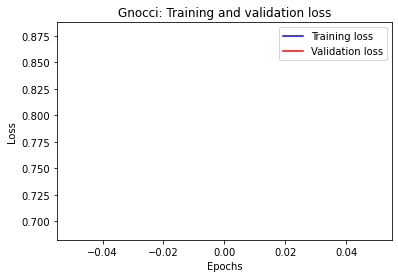

Training for kind: Kaffee/Schoko
33/33 [==============================] - 2s 47ms/step - loss: 0.8912 - val_loss: 0.8087


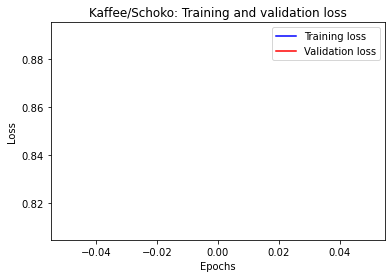

Training for kind: Schorlen
33/33 [==============================] - 2s 46ms/step - loss: 0.8913 - val_loss: 0.8344


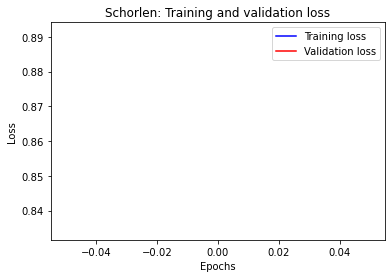

Training for kind: Salate
33/33 [==============================] - 2s 46ms/step - loss: 0.8828 - val_loss: 0.6845


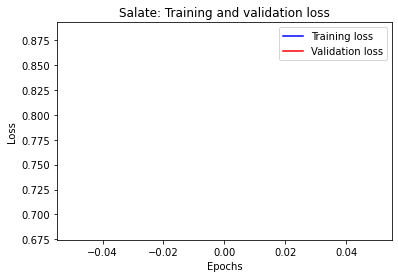

Training for kind: Dolci
33/33 [==============================] - 1s 45ms/step - loss: 0.9439 - val_loss: 0.7016


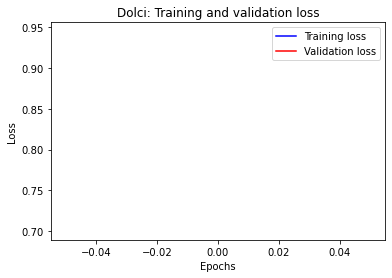

Training for kind: Specials
33/33 [==============================] - 1s 45ms/step - loss: 1.0808 - val_loss: 1.2334


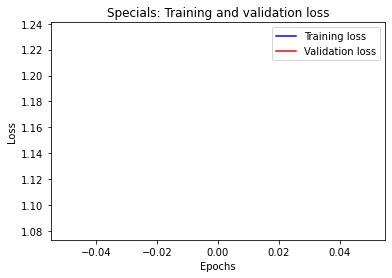

Training for kind: Aperitiv
33/33 [==============================] - 2s 46ms/step - loss: 0.9544 - val_loss: 0.8250


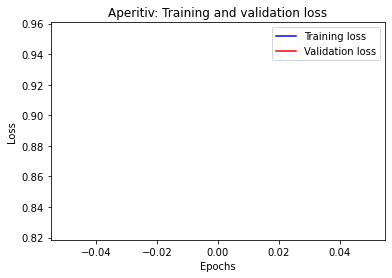

Training for kind: Cocktail alkfrei
33/33 [==============================] - 2s 46ms/step - loss: 0.2577 - val_loss: 2.3967


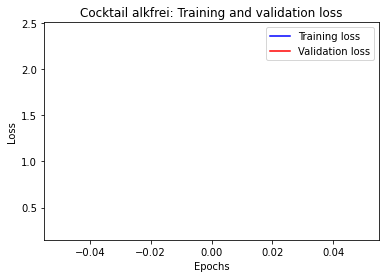

Training for kind: Extrabeilagen
33/33 [==============================] - 1s 44ms/step - loss: 0.4528 - val_loss: 1.4145


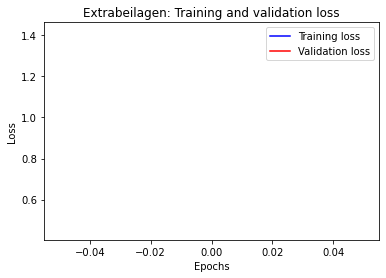

Training for kind: Suppen 
33/33 [==============================] - 1s 45ms/step - loss: 1.0587 - val_loss: 0.7548


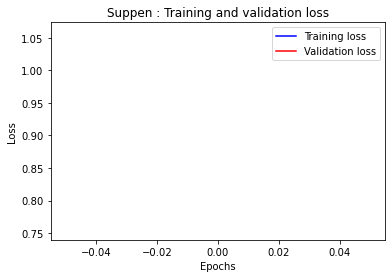

Training for kind: Säfte
33/33 [==============================] - 1s 45ms/step - loss: 0.9661 - val_loss: 0.8930


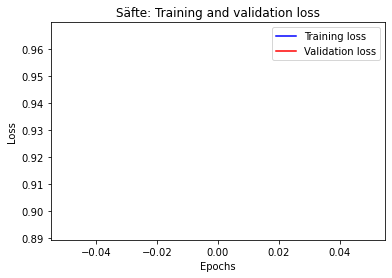

Training for kind: Spirituosen
33/33 [==============================] - 1s 45ms/step - loss: 0.9837 - val_loss: 0.9786


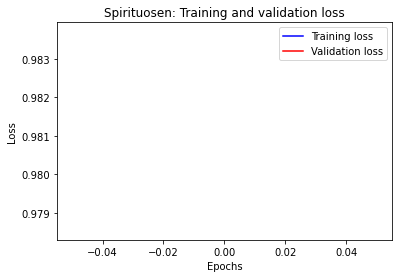

Training for kind: Cocktail
33/33 [==============================] - 1s 45ms/step - loss: 0.6060 - val_loss: 1.4228


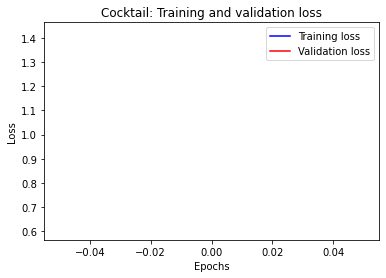

Training for kind: Eis
33/33 [==============================] - 1s 45ms/step - loss: 1.0009 - val_loss: 0.9716


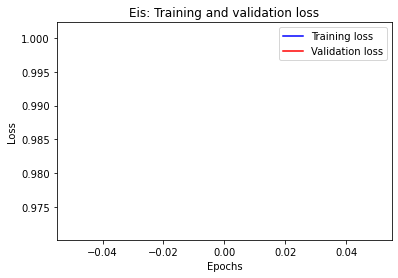

Training for kind: Salat
33/33 [==============================] - 1s 45ms/step - loss: 0.4789 - val_loss: 1.5602


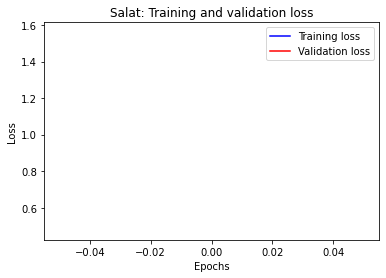

Training for kind: Handelswaren / Divers
33/33 [==============================] - 1s 45ms/step - loss: 1.8992 - val_loss: 0.0431


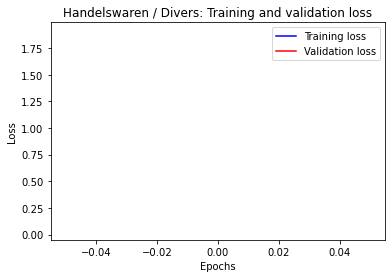

Training for kind: Infotexte
33/33 [==============================] - 2s 46ms/step - loss: 0.0062 - val_loss: 0.0016


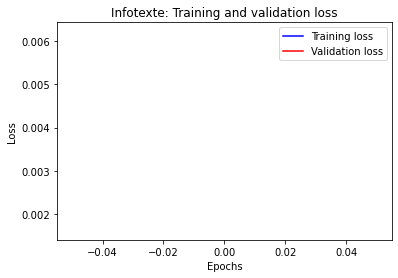

Training for kind: Mittagstisch
33/33 [==============================] - 1s 45ms/step - loss: 0.8489 - val_loss: 0.0422


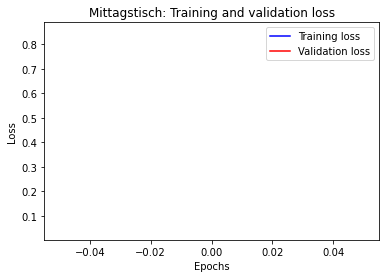

Training for kind: Rotwein offen
33/33 [==============================] - 1s 45ms/step - loss: 0.8622 - val_loss: 3.8842


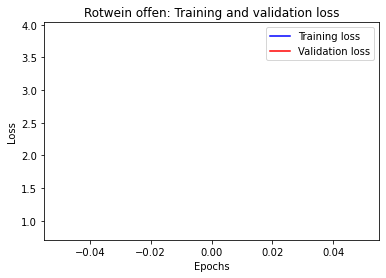

Training for kind: Prosecco
33/33 [==============================] - 2s 46ms/step - loss: 1.1377 - val_loss: 0.6520


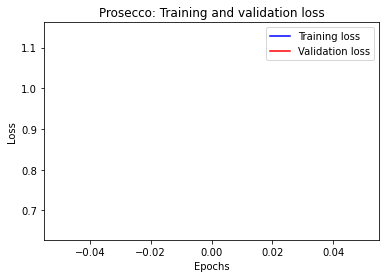

Training for kind: Weisswein Flasche
33/33 [==============================] - 2s 46ms/step - loss: 1.0284 - val_loss: 0.9007


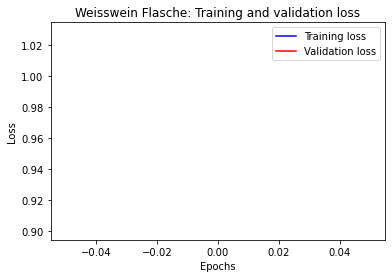

Training for kind: Rotwein Flasche
33/33 [==============================] - 2s 46ms/step - loss: 1.1032 - val_loss: 0.7152


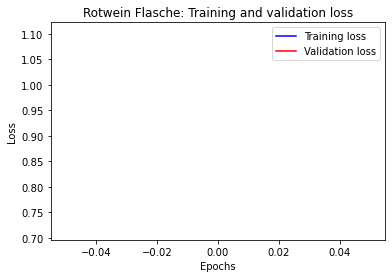

Training for kind: Suppe
33/33 [==============================] - 1s 44ms/step - loss: 1.6787 - val_loss: 0.0300


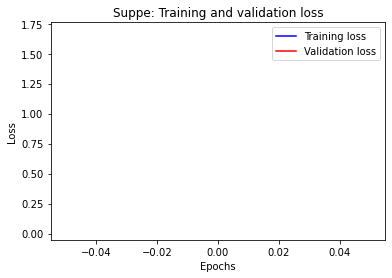

In [235]:
zv_kinds = {}
test_data_kinds = {}

for idx, kind in enumerate(kinds):
    print("Training for kind: %s" % kind)
    kind_sales = get_kind_ts(kind)
    kind_sales = augment_data(kind_sales)
    norm_kind, zv_kind = normalize(kind_sales)
    history_kind, test_data_kind = split_and_train(norm_kind, "model-%s" % idx)
    visualize_loss(history_kind, "%s: Training and validation loss" % kind)
    zv_kinds[kind] = zv_kind
    test_data_kinds[kind] = test_data_kind

## 10. Forecast all products

Forecast for: Pasta
            qty
2018-07-01   63
2018-07-02  110
2018-07-03  123
2018-07-04  157
2018-07-05  193
2018-07-06  205
2018-07-07   95
2018-07-08   79
2018-07-09  102
2018-07-10  130
2018-07-11  161
2018-07-12  202
2018-07-13  200
2018-07-14  107
Sum of predicted sales 14 days ahead: 1934
Forecast for: Limonaden
            qty
2018-07-01   73
2018-07-02   96
2018-07-03   91
2018-07-04   92
2018-07-05  139
2018-07-06  168
2018-07-07   82
2018-07-08   79
2018-07-09   90
2018-07-10   77
2018-07-11   80
2018-07-12  130
2018-07-13  161
2018-07-14   83
Sum of predicted sales 14 days ahead: 1447
Forecast for: Weisswein offen
            qty
2018-07-01   18
2018-07-02   34
2018-07-03   29
2018-07-04   39
2018-07-05   65
2018-07-06   64
2018-07-07   13
2018-07-08   28
2018-07-09   41
2018-07-10   34
2018-07-11   47
2018-07-12   66
2018-07-13   57
2018-07-14   14
Sum of predicted sales 14 days ahead: 555
Forecast for: Bier
            qty
2018-07-01   59
2018-07-02   86
2018-07-03 

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


            qty
2018-07-01    2
2018-07-02    1
2018-07-03    2
2018-07-04    4
2018-07-05    7
2018-07-06    7
2018-07-07    4
2018-07-08    2
2018-07-09    2
2018-07-10    3
2018-07-11    5
2018-07-12    6
2018-07-13    6
2018-07-14    4
Sum of predicted sales 14 days ahead: 64
Forecast for: Salat
            qty
2018-07-01    2
2018-07-02    1
2018-07-03    1
2018-07-04    2
2018-07-05    3
2018-07-06    4
2018-07-07    2
2018-07-08    1
2018-07-09    1
2018-07-10    1
2018-07-11    2
2018-07-12    2
2018-07-13    3
2018-07-14    2
Sum of predicted sales 14 days ahead: 34
Forecast for: Handelswaren / Divers


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model-24

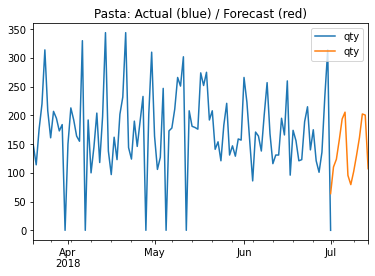

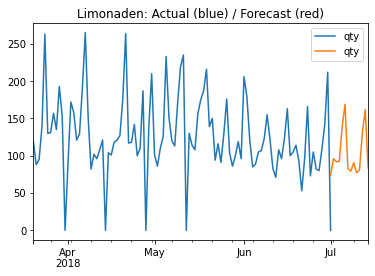

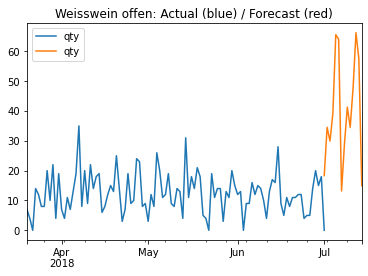

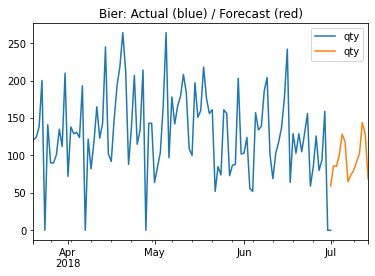

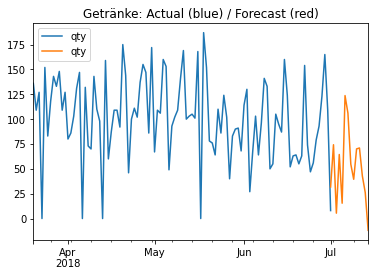

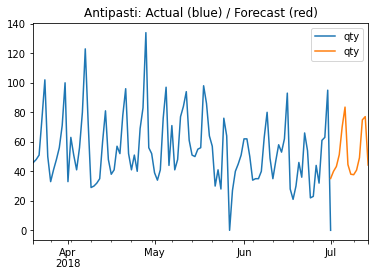

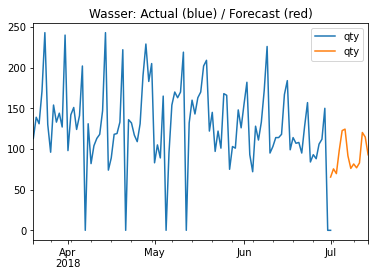

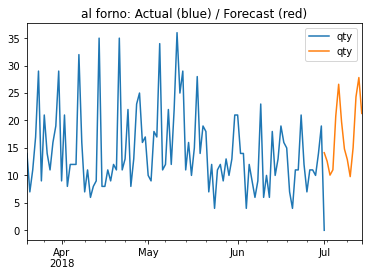

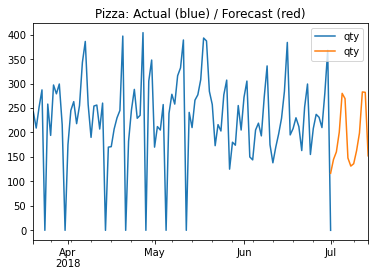

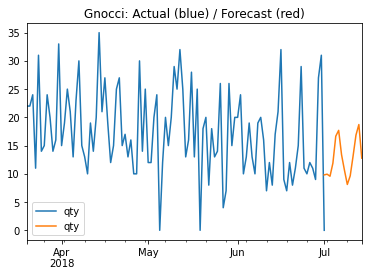

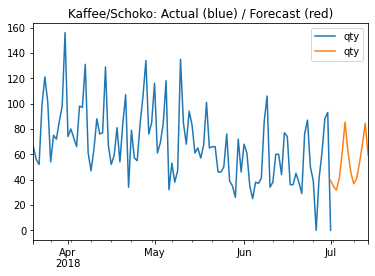

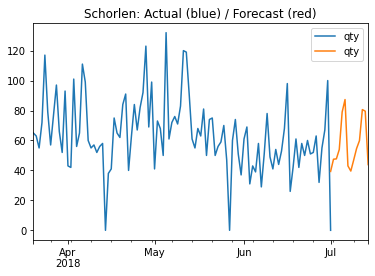

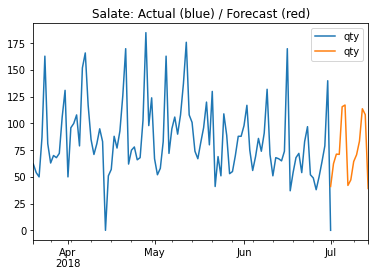

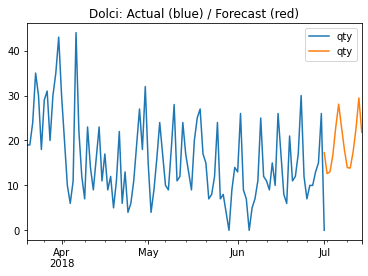

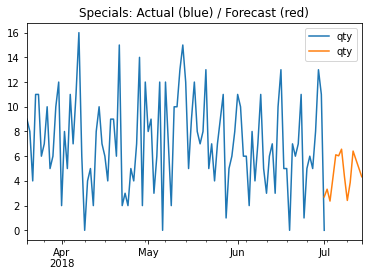

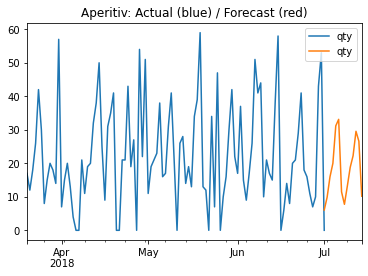

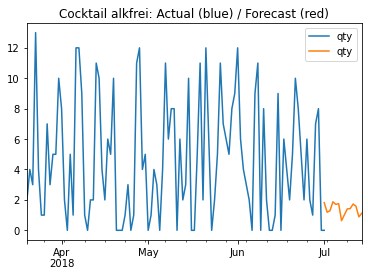

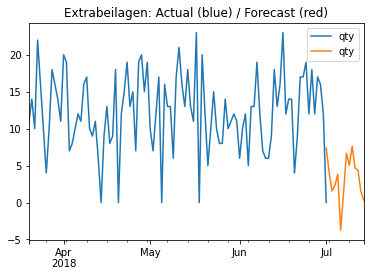

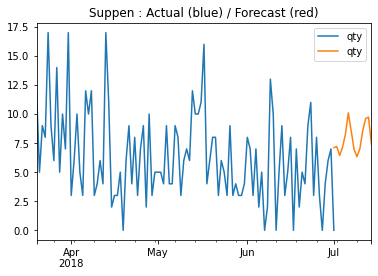

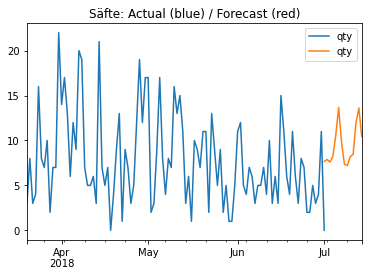

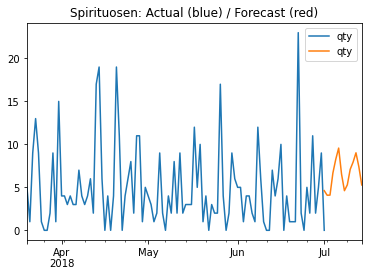

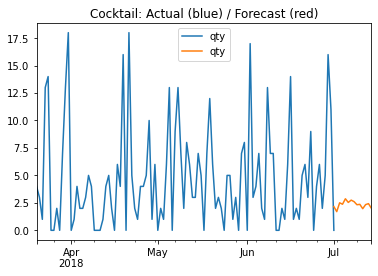

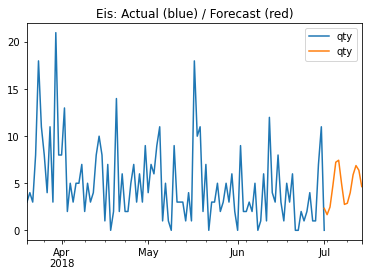

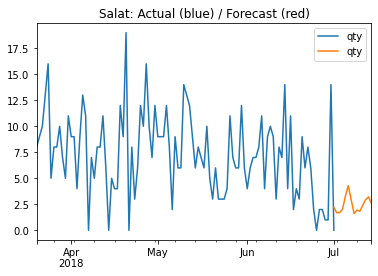

In [230]:
for idx, kind in enumerate(kinds):
    if kind in test_data_kinds:
        print("Forecast for: %s" % kind)
        test_data = test_data_kinds[kind]
        zv_kind = zv_kinds[kind]
        forecast_model(test_data, zv_kind, "model-%s" % idx, "%s: Actual (blue) / Forecast (red)" % kind)